In [87]:
import warnings
warnings.filterwarnings(action="ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from catboost import CatBoostClassifier

from mlxtend.classifier import StackingCVClassifier
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, make_scorer, f1_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from IPython.display import display
from sklearn.feature_selection import SelectKBest, f_classif 
from sklearn.decomposition import PCA

from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

In [88]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

In [89]:
train = pd.read_csv('../data/original/training_dataset.csv')
test = pd.read_csv('../data/original/evaluation_dataset.csv')

print(train['Bankrupt?'].value_counts())
print(test['Bankrupt?'].value_counts()) 

0    5279
1     176
Name: Bankrupt?, dtype: int64
0    1320
1      44
Name: Bankrupt?, dtype: int64


In [90]:
# Removes outliers. 1 bankrupt companie and 442 non banckrupt. 
def outliers_removal(feature, feature_name, dataset):
    q1 = np.percentile(feature, 25)
    q3 = np.percentile(feature, 75)
    iqr = q3 - q1
    fence = iqr * 1.5
    fence_lower = q1 - fence 
    fence_upper = q3 + fence
    outliers = [x for x in feature if x < fence_lower or x > fence_upper]
    dataset = dataset.drop(dataset[(dataset[feature_name] > fence_upper) | (dataset[feature_name] < fence_lower)].index)
    return dataset

# Only remove outliers from train data
for col in train:
    new_train = outliers_removal(train[col], str(col), train)

#Original
display(train['Bankrupt?'].value_counts())
# New
display(new_train['Bankrupt?'].value_counts())

0    5279
1     176
Name: Bankrupt?, dtype: int64

0    4837
1     175
Name: Bankrupt?, dtype: int64

In [91]:
y_train = new_train['Bankrupt?']
X_train = new_train.drop(['Bankrupt?'], axis = 1)

y_test = test['Bankrupt?']
X_test = test.drop(['Bankrupt?'], axis = 1)

print(y_train.value_counts())
print(y_test.value_counts()) 

0    4837
1     175
Name: Bankrupt?, dtype: int64
0    1320
1      44
Name: Bankrupt?, dtype: int64


In [92]:
# Try and also remove outliers with this method

# iso = IsolationForest(contamination=0.3)
# yhat = iso.fit_predict(X_train)

# # select all rows that are not outliers
# mask = yhat != -1
# X_train = X_train.to_numpy()
# y_train = y_train.to_numpy()
# print(X_train.shape, y_train.shape)
# X_train, y_train = X_train[mask, :], y_train[mask]
# print(X_train.shape, y_train.shape)

In [93]:
# Or remove outliers with this method

# ee = OneClassSVM(nu=0.03)
# yhat = ee.fit_predict(X_train)

# # select all rows that are not outliers
# mask = yhat != -1 
# X_train = X_train.to_numpy()
# y_train = y_train.to_numpy()
# print(X_train.shape, y_train.shape)
# X_train, y_train = X_train[mask, :], y_train[mask]
# print(X_train.shape, y_train.shape)

In [94]:
# Or remove outliers with this method

# lof = LocalOutlierFactor(n_neighbors=10, contamination=0.3)
# yhat = lof.fit_predict(X_train)

# mask = yhat != -1
# X_train = X_train.to_numpy()
# y_train = y_train.to_numpy()
# print(X_train.shape, y_train.shape)
# X_train, y_train = X_train[mask, :], y_train[mask]
# print(X_train.shape, y_train.shape)

In [95]:
from imblearn.over_sampling import SMOTE
from sklearn.metrics import fbeta_score, make_scorer
f2_scorer = make_scorer(fbeta_score, beta=2)

sc = MinMaxScaler()

# sc = StandardScaler() 

X_train = sc.fit_transform(X_train, y_train)
X_test = sc.transform(X_test)

skb = SelectKBest(f_classif, k=50)
X_train = skb.fit_transform(X_train,y_train)
X_test = skb.transform(X_test)

# pca = PCA(n_components=10) 
# X_train = pca.fit_transform(X_train)
# X_test = pca.transform(X_test)

sm = SMOTE(random_state=42, sampling_strategy='minority')
X_train, y_train = sm.fit_resample(X_train, y_train)

In [96]:
cros_val = StratifiedKFold(n_splits=5)

knn = KNeighborsClassifier(n_neighbors=9)
svm = SVC(C=1.4, gamma='scale', kernel='poly', random_state=42)
log_reg = LogisticRegression(penalty='l2', C=10, class_weight='balanced', solver='newton-cg', random_state=42) 
rf = RandomForestClassifier(max_features='log2', class_weight='balanced_subsample', criterion='entropy', bootstrap=True, random_state=42) #
cat  = CatBoostClassifier(auto_class_weights='SqrtBalanced', learning_rate=0.01, random_seed=42) 
xgb_clas = xgb.XGBClassifier(reg_alpha=0, eta=0.1, eval_metric='logloss', reg_lambda=1.5, max_depth=3)

stack = StackingCVClassifier(classifiers=[knn, svm, log_reg, rf, cat, xgb_clas],
                            meta_classifier=rf, 
                            cv=cros_val,
                            use_features_in_secondary=True,
                            store_train_meta_features=True,
                            shuffle=False,
                            random_state=42)

stack.fit(X_train, y_train)

0:	learn: 0.6814001	total: 12ms	remaining: 11.9s
1:	learn: 0.6668824	total: 22.2ms	remaining: 11.1s
2:	learn: 0.6561756	total: 33.5ms	remaining: 11.1s
3:	learn: 0.6462525	total: 44.9ms	remaining: 11.2s
4:	learn: 0.6352962	total: 55.6ms	remaining: 11.1s
5:	learn: 0.6222879	total: 66.5ms	remaining: 11s
6:	learn: 0.6130722	total: 78.9ms	remaining: 11.2s
7:	learn: 0.6015495	total: 91ms	remaining: 11.3s
8:	learn: 0.5922274	total: 102ms	remaining: 11.3s
9:	learn: 0.5837576	total: 113ms	remaining: 11.2s
10:	learn: 0.5741034	total: 125ms	remaining: 11.2s
11:	learn: 0.5644602	total: 136ms	remaining: 11.2s
12:	learn: 0.5558973	total: 147ms	remaining: 11.2s
13:	learn: 0.5480005	total: 160ms	remaining: 11.2s
14:	learn: 0.5385858	total: 171ms	remaining: 11.3s
15:	learn: 0.5312740	total: 184ms	remaining: 11.3s
16:	learn: 0.5250063	total: 197ms	remaining: 11.4s
17:	learn: 0.5167345	total: 209ms	remaining: 11.4s
18:	learn: 0.5082389	total: 223ms	remaining: 11.5s
19:	learn: 0.5020009	total: 237ms	remai

StackingCVClassifier(classifiers=[KNeighborsClassifier(n_neighbors=9),
                                  SVC(C=1.4, kernel='poly', random_state=42),
                                  LogisticRegression(C=10,
                                                     class_weight='balanced',
                                                     random_state=42,
                                                     solver='newton-cg'),
                                  RandomForestClassifier(class_weight='balanced_subsample',
                                                         criterion='entropy',
                                                         max_features='log2',
                                                         random_state=42),
                                  <catboost.core.CatBoostClassifier object at...
                                                   min_child_weight=None,
                                                   missing=nan,
                            

In [97]:
# # Make a prediction
# y_pred_test = stack.predict_proba(X_test) 

# y_pred_test = [el[1] for el in y_pred_test]

# # Change decision boundary (just for tuning the way you want your results to look like)
# decision_boundary = 0.01
# y_pred_test = [1 if y_pred_test[i] > decision_boundary else 0 for i in range(len(y_pred_test))]

              precision    recall  f1-score   support

           0       0.99      0.96      0.97      1320
           1       0.34      0.59      0.43        44

    accuracy                           0.95      1364
   macro avg       0.66      0.78      0.70      1364
weighted avg       0.97      0.95      0.96      1364

f1-score: 0.4333
f2-score: 0.5159


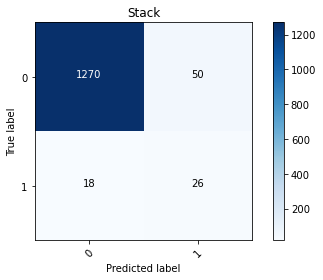

In [98]:
# Make a prediction
y_pred_test = stack.predict(X_test) 

# Print a classification report for our prediction
print(classification_report(y_test, y_pred_test))
print(f'f1-score: {round(f1_score(y_test, y_pred_test), 4)}')
print(f'f2-score: {round(fbeta_score(y_test, y_pred_test, beta=2), 4)}')

# Look at testing results in confusion matrix
test_conf_matrix = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(test_conf_matrix, classes=[0, 1], title='Stack')